In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn import metrics

In [6]:
train= pd.read_csv('C:/Users/Techa/Desktop/DataSet/Hackaton/financial-inclusion-in-africa/Train.csv')
test= pd.read_csv('C:/Users/Techa/Desktop/DataSet/Hackaton/financial-inclusion-in-africa/Test.csv')

In [7]:
train.shape, test.shape

((23524, 13), (10086, 12))

In [8]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [9]:

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [10]:
#1. map bank_account and cellphone_access to 0 and 1
def clean(train):
    #train = train.set_index('uniqueid')
    try:
        train['bank_account'] = train['bank_account'].map({'Yes': 1, 'No': 0})
    except KeyError: 
        print("go on")
    train['cellphone_access'] = train['cellphone_access'].map({'Yes': 1, 'No': 0})

    train['job_type'] = train['job_type'].map({'Self employed': 'Other Income','Informally employed': 'Other Income',
                                            'Farming and Fishing': 'Other Income','Remittance Dependent': 'Other Income',
                                                'No Income': 'Other Income', 'Formally employed Private':'Private',
                                                'Formally employed Government':'Goverment',
                                                'Government Dependent': 'Other Income','Government Dependent': 'Other Income' })
    train['job_type'] = train['job_type'].fillna(train['job_type'].mode()[0])
    train['education_level'] = train['education_level'].map({'Primary education': 'PrimaryOrInformal','No formal education': 'PrimaryOrInformal',
                                            'Secondary education': 'Secondary education','Tertiary education': 'Tertiary education',
                                                'Vocational/Specialised training':'PrimaryOrInformal',
                                                'Other/Dont know/RTA':'PrimaryOrInformal' })

    train['relationship_with_head'] = train['relationship_with_head'].map({'Head of Household': 'Head of Household','Spouse': 'Spouse',
                                            'Child': 'Child','Parent': 'Others',
                                                'Other relative':'Others',
                                                'Other non-relatives':'Others' })
    col= train.columns
    col_to_transform = ['country','location_type','gender_of_respondent', 'relationship_with_head', 'marital_status',
        'education_level', 'job_type']
    enc = OrdinalEncoder()
    train[col_to_transform] = enc.fit_transform(train[col_to_transform])
    
    return train



In [11]:
train = clean(train)

In [12]:
train.head(3)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.0,2018,uniqueid_1,1,0.0,1,3,24,0.0,3.0,2.0,1.0,1.0
1,0.0,2018,uniqueid_2,0,0.0,0,5,70,0.0,1.0,4.0,0.0,1.0
2,0.0,2018,uniqueid_3,1,1.0,1,5,26,1.0,2.0,3.0,0.0,1.0


In [13]:
y=train['bank_account'].values
X= train.drop(['bank_account', 'uniqueid'], axis=1).values
xtrain, xtest, ytrain, ytest= train_test_split(X, y, test_size=0.3, random_state=123)
scaler = StandardScaler()
xtrain= scaler.fit_transform(xtrain)
xtest= scaler.transform(xtest)  

In [17]:
lr = LogisticRegression()
rf= RandomForestClassifier()

In [19]:
def model_b(model, xtrain,ytrain, xtest, ytest):
    model.fit(xtrain,ytrain)
    acc= model.score(xtest, ytest)
    ypred= model.predict(xtest)
    mae= mean_absolute_error(ytest, ypred)
    # calculate AUC
    y_scores = model.predict_proba(xtest)
    auc = roc_auc_score(ytest,y_scores[:,1])
    fpr, tpr, thresholds = metrics.roc_curve(ytest, y_scores[:,1])
    return acc, mae, auc, fpr, tpr, thresholds


In [20]:
acclr, maelr, auclr, fprlr, tprlr, thresholdslr = model_b(lr, xtrain, ytrain, xtest, ytest)
print(f'The Logistic Regression Accuracy is {acclr}, MAE of {maelr}')

The Logistic Regression Accuracy is 0.8671011618022103, MAE of 0.13289883819778975


In [21]:
accrf, maerf, aucrf, fprrf, tprrf, thresholdsrf = model_b(rf, xtrain, ytrain, xtest, ytest)
print(f'The Logistic Regression Accuracy is {accrf}, MAE of {maerf}')

The Logistic Regression Accuracy is 0.8561915556814962, MAE of 0.14380844431850381


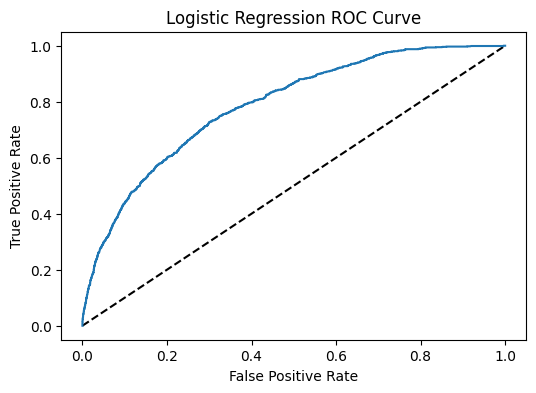

In [22]:
# plot ROC curve
#fpr, tpr, thresholds = metrics.roc_curve(ytest, y_scores[:,1])
fig = plt.figure(figsize=(6, 4))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fprlr, tprlr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.savefig("ROC-Curve.png")

## Evaluation

* I will use the Logistic Regression Model in predicting the outcome of the test dataset.

In [23]:
test= clean(test)

go on


In [24]:
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.0,2018,uniqueid_6056,1.0,1,3,30,1.0,1.0,2.0,1.0,0.0
1,0.0,2018,uniqueid_6060,1.0,1,7,51,1.0,1.0,2.0,0.0,2.0
2,0.0,2018,uniqueid_6065,0.0,0,3,77,0.0,2.0,2.0,0.0,1.0
3,0.0,2018,uniqueid_6072,0.0,0,6,39,0.0,1.0,2.0,0.0,1.0
4,0.0,2018,uniqueid_6073,1.0,0,3,16,1.0,0.0,3.0,1.0,1.0


In [25]:
test =test.set_index('uniqueid')

In [26]:
test.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
uniqueid,,,,,,,,,,,
uniqueid_6056,0.0,2018,1.0,1,3,30,1.0,1.0,2.0,1.0,0.0
uniqueid_6060,0.0,2018,1.0,1,7,51,1.0,1.0,2.0,0.0,2.0
uniqueid_6065,0.0,2018,0.0,0,3,77,0.0,2.0,2.0,0.0,1.0
uniqueid_6072,0.0,2018,0.0,0,6,39,0.0,1.0,2.0,0.0,1.0
uniqueid_6073,0.0,2018,1.0,0,3,16,1.0,0.0,3.0,1.0,1.0


In [27]:
val = test.values
val = scaler.transform(val)

In [28]:
valpred= lr.predict(val)
valpred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [29]:
test['PredictedBankAcc']= valpred
test['PredictedBankAcc'][:10]

uniqueid
uniqueid_6056    0
uniqueid_6060    0
uniqueid_6065    0
uniqueid_6072    0
uniqueid_6073    0
uniqueid_6074    0
uniqueid_6075    0
uniqueid_6076    0
uniqueid_6077    0
uniqueid_6078    1
Name: PredictedBankAcc, dtype: int64

In [30]:
test.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,PredictedBankAcc
uniqueid,,,,,,,,,,,,
uniqueid_6056,0.0,2018,1.0,1,3,30,1.0,1.0,2.0,1.0,0.0,0
uniqueid_6060,0.0,2018,1.0,1,7,51,1.0,1.0,2.0,0.0,2.0,0
uniqueid_6065,0.0,2018,0.0,0,3,77,0.0,2.0,2.0,0.0,1.0,0
uniqueid_6072,0.0,2018,0.0,0,6,39,0.0,1.0,2.0,0.0,1.0,0
uniqueid_6073,0.0,2018,1.0,0,3,16,1.0,0.0,3.0,1.0,1.0,0


In [34]:
#selecting prediction for Kenya only.
#our ordinal encoder has encoder Kenya as 0

predictionR= test[test['country']==0.0].iloc[:, [0,11]]
predictionR['country'] = predictionR['country'].map({0.0:'Kenya'})

In [36]:
predictionR[:10]

,country,PredictedBankAcc
uniqueid,,
uniqueid_6056,Kenya,0
uniqueid_6060,Kenya,0
uniqueid_6065,Kenya,0
uniqueid_6072,Kenya,0
uniqueid_6073,Kenya,0
uniqueid_6074,Kenya,0
uniqueid_6075,Kenya,0
uniqueid_6076,Kenya,0
uniqueid_6077,Kenya,0


In [39]:
#Uncomment to save to csv
#prediction = pd.DataFrame(test['PredictedBankAcc']).to_csv('victor_Jokanola_Submission.csv')
predictionR.to_csv('victor_Jokanola_Submission.csv')

In [125]:
enc.categories_

[array(['Kenya', 'Rwanda', 'Tanzania', 'Uganda'], dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Child', 'Head of Household', 'Others', 'Spouse'], dtype=object),
 array(['Divorced/Seperated', 'Dont know', 'Married/Living together',
        'Single/Never Married', 'Widowed'], dtype=object),
 array(['PrimaryOrInformal', 'Secondary education', 'Tertiary education'],
       dtype=object),
 array(['Goverment', 'Other Income', 'Private'], dtype=object)]

In [40]:
sub= pd.read_csv('C:/Users/Techa/Desktop/DataSet/Hackaton/financial-inclusion-in-africa/SampleSubmission.csv')
sub.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0
